In [2]:
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
%matplotlib inline

In [3]:
active_studs = pd.read_csv('active_studs.csv', sep=';')
checks       = pd.read_csv('checks.csv', sep=';')
groups       = pd.read_csv('groups.csv', sep=';')

In [4]:
plt.style.use('ggplot')

In [5]:
active_studs.dtypes

student_id    int64
dtype: object

In [6]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
active_studs.student_id = active_studs.student_id.apply(lambda x: str(x))
checks.student_id = checks.student_id.apply(lambda x: str(x))
groups = groups.rename(columns={'id': 'student_id'})
groups.student_id = groups.student_id.apply(lambda x: str(x))

In [9]:
df = active_studs.merge(checks, on='student_id', how='left').merge(groups, on='student_id').fillna(0)

In [10]:
df.grp = df.grp.apply(lambda x: x.replace('A', 'control'))
df.grp = df.grp.apply(lambda x: x.replace('B', 'test'))

In [11]:
df[df.grp == 'control'].rev.mean()

47.34720416124838

In [12]:
df[df.grp == 'test'].rev.mean()

58.05879810377775

In [13]:
df[df.grp == 'control'].query('rev > 0').shape[0] / df[df.grp == 'control'].shape[0]

0.05071521456436931

In [14]:
df[df.grp == 'test'].query('rev > 0').shape[0] / df[df.grp == 'test'].shape[0]

0.046156107599588415

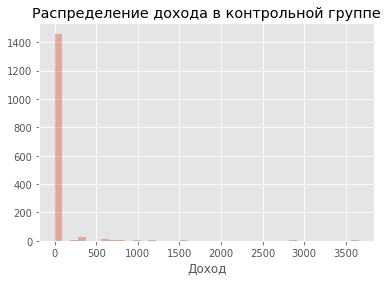

In [16]:
ax = sns.distplot((df[df.grp == 'control'].rev), kde=False)
ax.set_title('Распределение дохода в контрольной группе')
ax.set_xlabel('Доход')
plt.show()

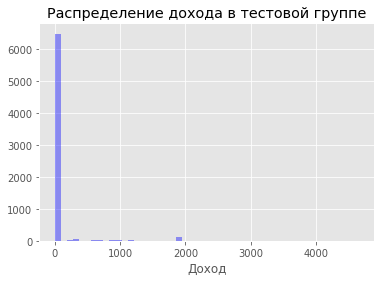

In [18]:
ax = sns.distplot(df[df.grp == 'test'].rev, kde=False, color='blue')
ax.set_title('Распределение дохода в тестовой группе')
ax.set_xlabel('Доход')
plt.show()

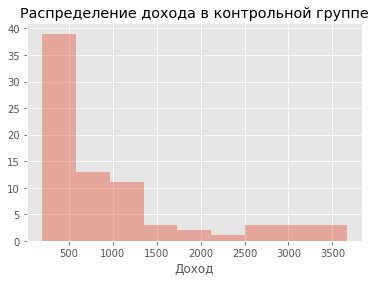

In [90]:
ax = sns.distplot(df[df.grp == 'control'].query('rev > 0').rev, kde=False)
ax.set_title('Распределение дохода в контрольной группе')
ax.set_xlabel('Доход')
plt.show()

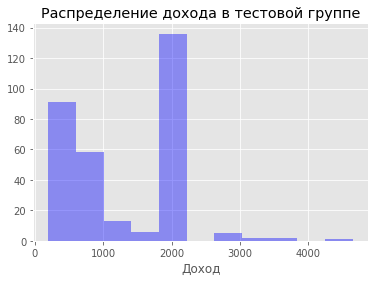

In [19]:
ay = sns.distplot(df[df.grp == 'test'].query('rev > 0').rev, kde=False, color='blue')
ay.set_title('Распределение дохода в тестовой группе')
ay.set_xlabel('Доход')
plt.show()

In [101]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Бутстрап-выборка')
    plt.ylabel('Частота')
    plt.title("Гистограмма бутстрап выборки")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

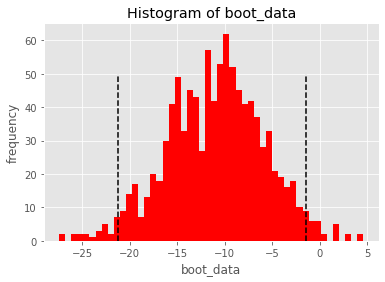

In [97]:
booted_df = get_bootstrap(df[df.grp == 'control'].rev, df[df.grp == 'test'].rev)

In [100]:
booted_df['p_value']

0.03200704934285375

## Полученные различия статистически значимы, то есть, в среднем, мы получаем больше денег с тех студентов, у которых установлена новая механика оплаты. Следовательно, мы можем распространить нововведение на всех пользователей.